<!-- <div style="background-color: rgb(247, 230, 202); border: 4px solid rgb(162, 87, 79); border-radius: 40px; padding: 20px; font-family: 'Roboto'; color: rgb(162, 87, 79); text-align: left; font-size: 120%;">
    <ul style="list-style-type: square; padding-left: 20px;">
        <li style="margin-top: 10px;">HLA columns are recalculated as per <a href="https://www.kaggle.com/code/albansteff/cibmtr-eda-ensemble-model-recalculate-hla" style="color: #A2574F; text-decoration: underline;">this</a> notebook.</li>
        <li style="margin-top: 10px;">Missing values are replaced with:
            <ul style="list-style-type: circle; margin-top: 10px; margin-bottom: 10px;">
                <li>-1 for numeric columns</li>
                <li>Unknown for categorical columns</li>
            </ul>
        </li>
        <li style="margin-top: 10px;">
            LightGBM and CatBoost are trained on 3 different targets, estimated from the survival models:
            <ul style="list-style-type: circle; margin-top: 10px; margin-bottom: 10px;">
                <li>Cox</li>
                <li>Kaplan-Meier</li>
                <li>Nelson-Aalen</li>
            </ul>
        </li>
        <li style="margin-top: 10px;">Two additional CatBoost model are trained, with Cox loss function.</li>
        <li style="margin-top: 10px;">As per <a href="https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/553061" style="color: #A2574F; text-decoration: underline;">this</a> discussion post, the target is consisted of the Out-of-Fold predictions of the survival models on the validation folds to prevent target leakage.</li>
        <li style="margin-top: 10px;">
            The ensemble prediction for each sample is computed as:
            <ul style="list-style-type: circle; margin-top: 10px; margin-bottom: 10px;">
                <p style="margin-top: 10px; font-size: 110%; color: #A2574F; font-family: 'Roboto'; text-align: left;">
                    $ \text{preds}_{\text{ensemble}} = \sum_{i=1}^{n} w_i \cdot \text{rankdata}(\text{preds}_i) $
                </p>
                where $n$ is the number of models, $w_i$ is the weight assigned to the $i$-th model, and $\text{rankdata}(\text{preds}_i)$ is the rank of predictions from the $i$-th model.
            </ul>
        </li>
        <li style="margin-top: 10px;">Last but not least, since the competition metric evaluates only the order of predictions and not their magnitude, the model weights are not required to sum to 1, nor should the predictions fall within a predefined range.</li>
    </ul>
</div> -->

<p style="font-size: 150%; text-align: left; border-radius: 40px 40px; color: rgb(232, 95, 9); font-weight: bold;">参考にしたNotebook</p>  

リンク  
- アンサンブル：https://www.kaggle.com/code/andreasbis/cibmtr-eda-ensemble-model  
- NN：https://www.kaggle.com/code/dreamingtree/single-nn-with-pairwise-ranking-loss-0-689-lb

<p style="font-size: 120%; text-align: left; border-radius: 40px 40px; color: rgb(244, 62, 7); font-weight: bold;">
概要
</p>  

- 特徴量エンジニアリング
    - 特徴量作成
        - ``hla_high_xxx``や``hla_low_xxx``といった特徴量は自分で作り直す
        - 複数の新たな特徴量を追加（add_featuresを参照）
- 欠損値補完
    - 数値列は``-1``
    - カテゴリ列は``Unknown``
- モデル
    - 種類（計８つのモデル）
        - ２つの予測モデル（LightGBMとCatBoost）×３つの生存確率推定モデル
            - コックス比例ハザードモデル
                - モデル概要
                    - セミパラメトリックモデル
                    - 共変量（複数の説明変数）を考慮できる
                    - 返す値は「相対的なリスクの大きさ」
                - データ処理
                    - １値しか取らないカラムを削除
                    - カテゴリ変数について``one hot encoding``を実施
            - カプラン・マイヤー推定量
                - ノンパラメトリックモデル（データからそのまま推定・特定の確率分布を仮定しない）
                - 共変量を考慮しない単純な推定
                - 生存確率を計算（０〜１）
                $$
                \begin{align*}
                S(t) &= \prod_{t_i \leq t} \left( 1 - \frac{d_i}{n_i} \right)  
                \end{align*}
                $$

                $$
                \begin{align*}
                t_i &\text{ はイベント発生時点} \\
                d_i &\text{ はその時点でのイベント発生個体数} \\
                n_i &\text{ はその時点での生存個体数}
                \end{align*}
                $$
            - ネルソン・アーレン推定量
                - ノンパラメトリックモデル（データからそのまま推定・特定の確率分布を仮定しない）
                - 共変量を考慮しない単純な推定
                - 累積ハザード確率を計算（０〜１）
                $$
                \begin{align*}
                H(t) &= \sum_{t_i \leq t} \frac{d_i}{n_i}
                \end{align*}
                $$
                $$
                \begin{align*}
                t_i &\text{ はイベント発生時点} \\
                d_i &\text{ はその時点でのイベント発生個体数} \\
                n_i &\text{ はその時点での生存個体数}
                \end{align*}
                $$
            - カプラン・マイヤーとネルソン・アーレンの違い
                - 「死亡のイベントが発生した時間に関数値が変化するという性質」は共通
                - ネルソン・アーレンは、「小さいサイズの標本に対してよりよい性質をもつ」
        - CatBoost（木の深さ優先 / 損失減少優先）× Cox回帰に基づく損失関数
            - CatBoost
                - ハイパーパラメータの設定の違い（木の深さ優先 / 損失減少優先）により2種類作成
                - 損失関数として「Cox回帰」を指定
            - Cox回帰に基づく損失関数
                - targetの設定
                    - 特定のイベントが発生せずに生存している期間を測定する指標を用いる
                    - イベントが発生しなかったデータについては生存時間を負にすることで、イベントが発生しなかったデータポイントを明確に区別できる
                - 予測モデル
                    - CatBoostにおいて、Cox回帰に基づく損失関数を使用
    - 特徴
        - ターゲットリークを防ぐため、ターゲットは検証フォールドにおけるサバイバルモデルのOut-of-Fold予測で構成される
            - https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/553061
        - アンサンブル予測は各サンプルについて以下のように計算される
            - アンサンブル予測 = Σ(wi * rankdata(predsi)) 
                - ここで、wiは i 番目のモデルに割り当てられた重み（<font color = "red">分析者が指定</font>）
                - rankdata(predsi)は i 番目のモデルの予測のランク
            - 競争メトリックが予測の大きさではなく順序のみを評価するため、モデルの重みは1に合計する必要はなく、予測も予め定義された範囲内である必要はありません。
- 精度評価
    - 層別C統計量を使用
        - 元のノートブックではmetricライブラリのscore関数を使用していたが、利用できないので代替
        - 層別C統計量は以前から使用していたもの


<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">ライブラリ</p>

In [1]:
# !pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
# !pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
# !pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
# !pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
# !pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl
# !pip install /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_lightning-2.4.0-py3-none-any.whl
# !pip install /kaggle/input/download-lightning-and-pytorch-tabular/scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
# !pip install /kaggle/input/download-lightning-and-pytorch-tabular/torchmetrics-1.5.2-py3-none-any.whl
# !pip install /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabnet-4.1.0-py3-none-any.whl
# !pip install /kaggle/input/download-lightning-and-pytorch-tabular/einops-0.7.0-py3-none-any.whl
# !pip install /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabular-1.1.1-py2.py3-none-any.whl

In [1]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import polars as pl #ライブラリのインポートに非常に時間がかかりそうだったので割愛
# import plotly.colors as pc
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.io as pio
# pio.renderers.default = 'iframe'

# 生存関数推定モデル
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines.utils import concordance_index #C-indexの計算

# sklearn
import sklearn.base
from sklearn.base import _fit_context
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# 予測モデル
import lightgbm as lgb
import optuna
from catboost import CatBoostRegressor
from scipy.stats import rankdata

#NN用
import torch
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import TensorDataset

import functools
from typing import List

import pytorch_lightning as pl
import numpy as np
import torch
from lifelines.utils import concordance_index
from pytorch_lightning.cli import ReduceLROnPlateau
from pytorch_tabular.models.common.layers import ODST
from torch import nn
from pytorch_lightning.utilities import grad_norm

import json

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
from sklearn.model_selection import StratifiedKFold

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">データインポート</p>

In [ ]:
# INPUT_DIRにディレクトリを指定

pd.options.display.max_columns = None

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">パラメータ設定【CFG】</p>

重みや正則化パラメータは自分で決定

In [4]:
# クラス変数（クラス全体で共有される変数）の定義
class CFG:
    # train_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/train.csv') 
    # test_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/test.csv') 
    # subm_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv') 
    train_path = INPUT_DIR + "/train.csv"
    test_path = INPUT_DIR + "/test.csv"
    subm_path = INPUT_DIR + "/sample_submission.csv"

    # colorscale = 'red' # 可視化に使用するカラースケールの指定
    color = '#A2574F' # 可視化に使用するカラーパレットの指定

    early_stop = 300 # 早期終了のパラメータ（一定エポック改善がない場合に終了）
    penalizer = 0.01 # 正則化パラメータの設定
    n_splits = 5 # クロスバリデーションの分割数

    weights = [
        2,
        1,
        6,
        3,
        6,
        3,
        6,
        6,
        6,
    ] # 特定のモデルやデータに対する重みのリスト

    ctb_params = { # CatBoostモデルのハイパーパラメータ
        'loss_function': 'RMSE', # 損失関数としてRMSEを使用
        'learning_rate': 0.03, # 学習率
        'random_state': 42, # 乱数シード
        'task_type': 'CPU', # モデルをCPUで実行
        'num_trees': 6000, # 決定木の数
        'reg_lambda': 8.0, # L2正則化の強さ
        'depth': 8 # 決定木の深さ
    }

    lgb_params = { # LightGBMモデルのハイパーパラメータ
        'objective': 'regression', # 回帰タスクを指定
        'min_child_samples': 32, # ノードごとの最小データ数
        'num_iterations': 6000, # イテレーション回数
        'learning_rate': 0.03, # 学習率
        'extra_trees': True, # Extra Trees方式を使用
        'reg_lambda': 8.0, # L2正則化の強さ
        'reg_alpha': 0.1, # L1正則化の強さ
        'num_leaves': 64, # 決定木の葉の数
        'metric': 'rmse', # 評価指標としてRMSEを使用
        'max_depth': 8, # 決定木の深さの最大値
        'device': 'cpu', # モデルをCPUで実行
        'max_bin': 128, # ビンの最大数
        'verbose': -1, # ログ出力の抑制
        'seed': 42 # 乱数シード
    }

    cox1_params = { # Coxモデルのハイパーパラメータ（Depthwiseの成長ポリシー）
        'grow_policy': 'Depthwise', # 木の深さに基づいた成長ポリシー （デフォルトは"SymmetricTree"（対照ツリー））
        'min_child_samples': 8, # ノードごとの最小データ数
        'loss_function': 'Cox', # 損失関数としてCox回帰を使用
        'learning_rate': 0.03, # 学習率
        'random_state': 42, # 乱数シード
        'task_type': 'CPU', # モデルをCPUで実行
        'num_trees': 6000, # 決定木の数
        'reg_lambda': 8.0, # L2正則化の強さ
        'depth': 8 # 決定木の深さ
    }

    cox2_params = { # Coxモデルのハイパーパラメータ（Lossguideの成長ポリシー）
        'grow_policy': 'Lossguide', # データ損失に基づいた成長ポリシー
        'min_child_samples': 2, # ノードごとの最小データ数
        'loss_function': 'Cox', # 損失関数としてCox回帰を使用
        'learning_rate': 0.03, # 学習率
        'random_state': 42, # 乱数シード
        'task_type': 'CPU', # モデルをCPUで実行
        'num_trees': 6000, # 決定木の数
        'reg_lambda': 8.0, # L2正則化の強さ
        'num_leaves': 32, # 決定木の葉の数
        'depth': 8 # 決定木の深さ
    }

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">特徴量エンジニアリング【FE】</p>

In [13]:
class FE:
    def __init__(self):
        pass # 初期化メソッドには何も処理を行わない

    def _load_data(self, path):
        df = pd.read_csv(path)
        return df

    def _update_hla_columns(self, df): # "hla_high_xxx"、"hla_low_xxx"系の特徴量について、既知のデータを用いずに自分で作成
        df['hla_nmdp_6'] = (
            df['hla_match_a_low'].fillna(0)
            + df['hla_match_b_low'].fillna(0)
            + df['hla_match_drb1_high'].fillna(0)
        )
        df['hla_low_res_6'] = (
            df['hla_match_a_low'].fillna(0)
            + df['hla_match_b_low'].fillna(0)
            + df['hla_match_drb1_low'].fillna(0)
        )
        df['hla_high_res_6'] = (
            df['hla_match_a_high'].fillna(0)
            + df['hla_match_b_high'].fillna(0)
            + df['hla_match_drb1_high'].fillna(0)
        )
        df['hla_low_res_8'] = (
            df['hla_match_a_low'].fillna(0)
            + df['hla_match_b_low'].fillna(0)
            + df['hla_match_c_low'].fillna(0)
            + df['hla_match_drb1_low'].fillna(0)
        )
        df['hla_high_res_8'] = (
            df['hla_match_a_high'].fillna(0)
            + df['hla_match_b_high'].fillna(0)
            + df['hla_match_c_high'].fillna(0)
            + df['hla_match_drb1_high'].fillna(0)
        )
        df['hla_low_res_10'] = (
            df['hla_match_a_low'].fillna(0)
            + df['hla_match_b_low'].fillna(0)
            + df['hla_match_c_low'].fillna(0)
            + df['hla_match_drb1_low'].fillna(0)
            + df['hla_match_dqb1_low'].fillna(0)
        )
        df['hla_high_res_10'] = (
            df['hla_match_a_high'].fillna(0)
            + df['hla_match_b_high'].fillna(0)
            + df['hla_match_c_high'].fillna(0)
            + df['hla_match_drb1_high'].fillna(0)
            + df['hla_match_dqb1_high'].fillna(0)
        )
        return df

    def _cast_datatypes(self, df): # 欠損値の補完
        num_cols = [
            'hla_high_res_8', 'hla_low_res_8', 'hla_high_res_6', 'hla_low_res_6',
            'hla_high_res_10', 'hla_low_res_10', 'hla_match_dqb1_high',
            'hla_match_dqb1_low', 'hla_match_drb1_high', 'hla_match_drb1_low',
            'hla_nmdp_6', 'year_hct', 'hla_match_a_high', 'hla_match_a_low',
            'hla_match_b_high', 'hla_match_b_low', 'hla_match_c_high',
            'hla_match_c_low', 'donor_age', 'age_at_hct', 'comorbidity_score',
            'karnofsky_score', 'efs', 'efs_time',
            'age_ts', 'age_comorbidity', 'age_karnofsky', 'karnofsky_squared'
            'cos_year', 'diff_age_vs_donor'
        ]
        for col in df.columns:
            if col in num_cols:
                df[col] = df[col].fillna(-1).astype('float32') # 数値型の場合は欠損値を-1で補完
            else:
                df[col] = df[col].astype(str).fillna('Unknown').astype('category') # カテゴリ型の場合は欠損値を'Unknown'で補完
        df['ID'] = df['ID'].astype('int32') # データ型の変更
        return df
    
    def add_features(self, df):
        sex_match = df.sex_match.astype(str)
        sex_match = sex_match.str.split("-").str[0] == sex_match.str.split("-").str[1]
        df['sex_match_bool'] = sex_match
        df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan
        df.loc[df.year_hct == 2019, 'year_hct'] = 2020
        df['is_cyto_score_same'] = (df['cyto_score'] == df['cyto_score_detail']).astype(int)
        df['age_bin'] = pd.cut(df.age_at_hct, [0, 0.0441, 16, 30, 50, 100])
        df['age_ts'] = df.age_at_hct / df.donor_age
        df['age_comorbidity'] = df['age_at_hct'] * df['comorbidity_score']
        df['age_karnofsky'] = df['age_at_hct'] * df['karnofsky_score']
        df['karnofsky_squared'] = df['karnofsky_score'] ** 2
        df['cos_year'] = np.cos(df['year_hct'] * (2 * np.pi) / 100)
        df['diff_age_vs_donor'] = df['age_at_hct'] - df['donor_age']
        # sex_one: 性別一致情報から患者の性別を抽出
        df['sex_one'] = df['sex_match'].str[0]  # 最初の文字を抽出
        # sex_two: 性別一致情報からドナーの性別を抽出
        df['sex_two'] = df['sex_match'].str[2]  # 3番目の文字を抽出
        # SameSex: 患者とドナーの性別が一致しているか
        df['same_sex'] = (df['sex_one'] == df['sex_two']).astype(int)
        return df

    def info(self, df): #データフレームのメモリ使用量を確認
        print(f'\nShape of dataframe: {df.shape}')
        mem = df.memory_usage().sum() / 1024**2
        print('Memory usage: {:.2f} MB\n'.format(mem))
        print(df.head())

    # ディープラーニング用の前処理を行う関数
    def preprocess_data(self, df_train, val):
        X_cat_train, X_cat_val, numerical, transformers = self.get_categoricals(df_train, val) # カテゴリカル変数と数値変数を取得・加工
        scaler = StandardScaler() # 数値データの標準化
        imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True) # 欠損値を平均値で補完
        # 訓練データの数値変数を補完し、標準化
        X_num_train = imp.fit_transform(df_train[numerical])
        X_num_train = scaler.fit_transform(X_num_train)
        # 検証データの数値変数を補完し、標準化
        X_num_val = imp.transform(val[numerical])
        X_num_val = scaler.transform(X_num_val)
        # ディープラーニング用のデータセットを作成
        dl_train = self.init_dl(X_cat_train, X_num_train, df_train, training=True)
        dl_val = self.init_dl(X_cat_val, X_num_val, val)
        return X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers

    # ディープラーニング用のデータローダーを作成
    def init_dl(self, X_cat, X_num, df_train, training=False):
        ds_train = TensorDataset(
            torch.tensor(X_cat, dtype=torch.long),  # カテゴリカル変数をテンソルに変換
            torch.tensor(X_num, dtype=torch.float32),  # 数値変数をテンソルに変換
            torch.tensor(df_train.efs_time.values, dtype=torch.float32).log(),  # efs_timeを対数変換
            torch.tensor(df_train.efs.values, dtype=torch.long)  # efsを整数として扱う
        )
        # バッチサイズを設定（訓練時と検証時で異なる可能性）
        bs = 2048
        # データローダーを作成
        dl_train = torch.utils.data.DataLoader(ds_train, batch_size=bs, pin_memory=True, shuffle=training)
        return dl_train

    def get_feature_types(df_train): # カテゴリ変数と数値変数をそれぞれ取得する関数
        categorical_cols = [col for i, col in enumerate(df_train.columns) if ((df_train[col].dtype == "object") | (2 < df_train[col].nunique() < 25))] # カテゴリ変数の条件：オブジェクト型または一意な値が3以上25未満
        RMV = ["ID", "efs", "efs_time", "y"] # 除外する特徴量
        FEATURES = [c for c in df_train.columns if not c in RMV]
        print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")
        numerical = [i for i in FEATURES if i not in categorical_cols] # 数値変数のリストを作成
        return categorical_cols, numerical

    # ラベルエンコーディングを行い、カテゴリカル変数を整数に変換する関数
    def get_X_cat(self, df_train, cat_cols, transformers=None):
        if transformers is None:
            # 各カテゴリカル変数に対してLabelEncoderを適用し、エンコーダを作成
            transformers = [LabelEncoder().fit(df_train[col]) for col in cat_cols]
        return transformers, np.array(
            # 各カテゴリカル変数をエンコードし、数値の配列として返す
            [transformer.transform(df_train[col]) for col, transformer in zip(cat_cols, transformers)]
        ).T

    # カテゴリカル変数と数値変数を取得・加工する関数
    def get_categoricals(self, df_train, val):
        categorical_cols, numerical = self.get_feature_types(df_train) # カテゴリ変数と数値変数をそれぞれ取得
        remove = []
        for col in categorical_cols: # 一意の値が1つしかないカテゴリ変数を削除
            if df_train[col].nunique() == 1:
                remove.append(col)
            ind = ~val[col].isin(df_train[col]) # 検証データに訓練データに存在しない値がある場合、欠損値に変換
            if ind.any():
                val.loc[ind, col] = np.nan
        categorical_cols = [col for col in categorical_cols if col not in remove] # 削除対象を除外したカテゴリ変数リストを更新
        transformers, X_cat_train = self.get_X_cat(df_train, categorical_cols) # カテゴリ変数をラベルエンコーディング
        _, X_cat_val = self.get_X_cat(val, categorical_cols, transformers)
        return X_cat_train, X_cat_val, numerical, transformers

    def apply_fe(self, path): # 特徴量エンジニアリング（勾配ブースティング）
        df = self._load_data(path) # pathのデータを読み込む
        df = self._update_hla_columns(df) # hla_high_xxx、hla_low_xxx系の特徴量を追加
        df = self.add_features(df) # 特徴量の追加
        df = self._cast_datatypes(df) # 欠損値の補完
        self.info(df) # データフレームのメモリ確認
        cat_cols = [col for col in df.columns if df[col].dtype == 'category']
        return df, cat_cols

    def apply_fe_nn(self, path): # 特徴量エンジニアリング（ニューラル）
        df = self._load_data(path) # pathのデータを読み込む
        df = self._update_hla_columns(df) # hla_high_xxx、hla_low_xxx系の特徴量を追加
        df = self.add_features(df) # 特徴量の追加
        return df

In [14]:
# インスタンス作成
fe = FE()
df_train, cat_cols = fe.apply_fe(CFG.train_path)


Shape of dataframe: (28800, 72)
Memory usage: 4.38 MB

   ID                       dri_score psych_disturb    cyto_score diabetes  \
0   0  N/A - non-malignant indication            No           nan       No   
1   1                    Intermediate            No  Intermediate       No   
2   2  N/A - non-malignant indication            No           nan       No   
3   3                            High            No  Intermediate       No   
4   4                            High            No           nan       No   

   hla_match_c_high  hla_high_res_8          tbi_status arrhythmia  \
0              -1.0             6.0              No TBI         No   
1               2.0             8.0  TBI +- Other, >cGy         No   
2               2.0             8.0              No TBI         No   
3               2.0             8.0              No TBI         No   
4               2.0             8.0              No TBI         No   

   hla_low_res_6        graft_type vent_hist renal_iss

In [ ]:
test_data, _ = fe.apply_fe(CFG.test_path)


Shape of dataframe: (3, 58)
Memory usage: 0.00 MB

      ID                       dri_score psych_disturb    cyto_score diabetes  \
0  28800  N/A - non-malignant indication            No       Unknown       No   
1  28801                    Intermediate            No  Intermediate       No   
2  28802  N/A - non-malignant indication            No       Unknown       No   

   hla_match_c_high  hla_high_res_8          tbi_status arrhythmia  \
0              -1.0             6.0              No TBI         No   
1               2.0             8.0  TBI +- Other, >cGy         No   
2               2.0             8.0              No TBI         No   

   hla_low_res_6        graft_type vent_hist renal_issue pulm_severe  \
0            6.0       Bone marrow        No          No          No   
1            6.0  Peripheral blood        No          No          No   
2            6.0       Bone marrow        No          No          No   

  prim_disease_hct  hla_high_res_6 cmv_status  hla_hi

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">可視化【EDA】</p>

In [ ]:
class EDA:
    def __init__(self, color, data):
        # self._colorscale = sns.color_palette(colorscale)
        self._color = color
        self.data = data

    def _template(self, ax, title):
        ax.set_title(title, fontsize=16, color=self._color, ha='center')
        # ax.set_facecolor('rgba(247, 230, 202, 1)')
        ax.grid(True, axis='x', color='grey', linestyle='-', linewidth=0.5)
        ax.grid(True, axis='y', color='grey', linestyle='-', linewidth=0.5)
        ax.tick_params(axis='both', colors=self._color)
        ax.set_xlabel('Values', color=self._color)
        ax.set_ylabel('Count', color=self._color)
        return ax

    def distribution_plot(self, col, title):
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.histplot(self.data[col], bins=100, color=self._color, ax=ax)
        ax = self._template(ax, f'{title}')
        plt.show()

    def bar_chart(self, col):
        value_counts = self.data[col].value_counts().reset_index()
        value_counts.columns = [col, 'count']

        fig, ax = plt.subplots(figsize=(8, 6))
        sns.barplot(data=value_counts, x='count', y=col, ax=ax)

        ax = self._template(ax, f'{col}')
        ax.set_xlabel('Count')
        ax.set_ylabel('')
        plt.show()

    def _plot_cv(self, scores, title, metric='Stratified C-Index'):
        fold_scores = [round(score, 3) for score in scores]
        mean_score = round(np.mean(scores), 3)

        fig, ax = plt.subplots(figsize=(8, 6))

        ax.scatter(range(1, len(fold_scores) + 1), fold_scores, color=self._color, s=100, label='Fold Scores', marker='D')

        ax.plot([1, len(fold_scores)], [mean_score, mean_score], color='#B22222', linestyle='--', label=f'Mean: {mean_score:.3f}')
        
        ax.set_title(f'{title} | Cross-validation Mean {metric} Score: {mean_score}', fontsize=16, color=self._color, ha='center')
        ax.set_xlabel('Fold', color=self._color)
        ax.set_ylabel(f'{metric} Score', color=self._color)
        
        ax.legend()
        ax.set_xticks(range(1, len(fold_scores) + 1))
        ax.set_ylim(min(fold_scores) - 0.05, max(fold_scores) + 0.05)

        ax = self._template(ax, f'{title} Cross-validation')
        plt.show()

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">生存確率（目的変数）の推定【Targets】</p>

特徴的な点  
- カテゴリ変数にone hot encodingを実施
- cvにおいて一つの値しか取らないカラムを削除

In [ ]:
class Targets:
    def __init__(self, data, cat_cols, penalizer, n_splits):
        self.data = data
        self.cat_cols = cat_cols
        self._length = len(self.data)
        self._penalizer = penalizer
        self._n_splits = n_splits

    def _prepare_cv(self): # cvのためのデータ分割
        oof_preds = np.zeros(self._length)
        cv = KFold(n_splits=self._n_splits, shuffle=True, random_state=42)
        return cv, oof_preds

    def score(self, df_true, df_prediction, event_label, interval_label, prediction_label): #層別C-indexの計算
        # ID列を削除
        del df_true["ID"]
        del df_prediction["ID"]

        merged_df = pd.concat([df_true, df_prediction], axis=1)
        merged_df.reset_index(inplace=True)
        merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups) # 人種ごとに該当するデータのインデックスを辞書形式で保管
        metric_list = []
        for race in merged_df_race_dict.keys(): #人種ごと
            indices = sorted(merged_df_race_dict[race]) #該当する人種のインデックスを取得
            merged_df_race = merged_df.iloc[indices] # 該当するインデックスのデータを取得
            c_index_race = concordance_index( # concordance_indexはefs, efs_time, predicton（生存確率）からC-indexを計算
                merged_df_race[interval_label],
                -merged_df_race[prediction_label], # 符号を反転（通常 C-Index は「リスクが高いほど短命」と仮定するため）
                merged_df_race[event_label])
            metric_list.append(c_index_race)
        return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

    def validate_model(self, preds, title):
        y_true = self.data[['ID', 'efs', 'efs_time', 'race_group']].copy()
        y_pred = self.data[['ID']].copy()
        y_pred['prediction'] = preds
        c_index_score = self.score(y_true.copy(), y_pred.copy(), "efs", "efs_time", "prediction")
        print(f'Overall Stratified C-Index Score for {title}: {c_index_score:.4f}')

    def create_target1(self): # Cox比例ハザードモデル
        '''
        Constant columns are dropped if they exist in a fold. Otherwise, the code produces error:
        delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: 
        https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
        '''
        cv, oof_preds = self._prepare_cv() #データ分割
        data = pd.get_dummies(self.data, columns=self.cat_cols, drop_first=True).drop('ID', axis=1) # カテゴリ変数にone hot encodingを実施

        for fold, (train_index, valid_index) in enumerate(cv.split(data), 1):
            df_train = data.iloc[train_index]
            valid_data = data.iloc[valid_index]
            unique_columns = df_train.nunique() > 1
            removed_columns = df_train.columns[~unique_columns] # 一つの値しか取らないカラムを削除
            df_train = df_train.loc[:, unique_columns]
            valid_data = valid_data[df_train.columns]
            print(f"Fold {fold}:")
            print(f"Removed columns: {list(removed_columns)}") # 削除されたカラムとその数を表示
            print(f"Number of removed columns: {len(removed_columns)}")
            cph = CoxPHFitter(penalizer=self._penalizer) # Cox比例ハザードモデルのインスタンス作成（penalizer：正則化の強さ（過学習を防止する目的））
            cph.fit(df_train, duration_col='efs_time', event_col='efs')
            oof_preds[valid_index] = cph.predict_partial_hazard(valid_data)

        self.data['target1'] = oof_preds
        self.validate_model(oof_preds, 'Cox')
        return self.data

    def create_target2(self): # Kaplan-Meier生存関数モデル
        cv, oof_preds = self._prepare_cv() #データ分割

        for train_index, valid_index in cv.split(self.data):
            df_train = self.data.iloc[train_index]
            valid_data = self.data.iloc[valid_index]
            kmf = KaplanMeierFitter()
            kmf.fit(durations=df_train['efs_time'], event_observed=df_train['efs'])
            oof_preds[valid_index] = kmf.survival_function_at_times(valid_data['efs_time']).values

        self.data['target2'] = oof_preds
        self.validate_model(oof_preds, 'Kaplan-Meier')

        return self.data

    def create_target3(self): # Nelson-Aalen生存関数モデル
        cv, oof_preds = self._prepare_cv()
        for train_index, valid_index in cv.split(self.data):
            df_train = self.data.iloc[train_index]
            valid_data = self.data.iloc[valid_index]
            naf = NelsonAalenFitter()
            naf.fit(durations=df_train['efs_time'], event_observed=df_train['efs'])
            oof_preds[valid_index] = -naf.cumulative_hazard_at_times(valid_data['efs_time']).values

        self.data['target3'] = oof_preds
        self.validate_model(oof_preds, 'Nelson-Aalen')
        return self.data

    def create_target4(self): # 
        self.data['target4'] = self.data.efs_time.copy()
        self.data.loc[self.data.efs == 0, 'target4'] *= -1
        return self.data

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">モデル構築【MD】</p>

In [ ]:
class MD:
    def __init__(self,color, data, cat_cols, early_stop, penalizer, n_splits):
        self.eda = EDA(color, data) # EDAクラスのインスタンス作成
        self.targets = Targets(data, cat_cols, penalizer, n_splits) # Targetsクラスのインスタンス作成
        self.data = data
        self.cat_cols = cat_cols
        self.early_stop = early_stop

    def create_targets(self): # 4種類の生存確率
        self.data = self.targets.create_target1()
        self.data = self.targets.create_target2()
        self.data = self.targets.create_target3()
        self.data = self.targets.create_target4()
        return self.data

    def score(self, df_true, df_prediction, event_label, interval_label, prediction_label): #層別C-indexの計算
        # ID列を削除
        del df_true["ID"]
        del df_prediction["ID"]

        merged_df = pd.concat([df_true, df_prediction], axis=1)
        merged_df.reset_index(inplace=True)
        merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups) # 人種ごとに該当するデータのインデックスを辞書形式で保管
        metric_list = []
        for race in merged_df_race_dict.keys(): #人種ごと
            indices = sorted(merged_df_race_dict[race]) #該当する人種のインデックスを取得
            merged_df_race = merged_df.iloc[indices] # 該当するインデックスのデータを取得
            c_index_race = concordance_index( # concordance_indexはefs, efs_time, predicton（生存確率）からC-indexを計算
                merged_df_race[interval_label],
                -merged_df_race[prediction_label], # 符号を反転（通常 C-Index は「リスクが高いほど短命」と仮定するため）
                merged_df_race[event_label])
            metric_list.append(c_index_race)
        return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

    def train_model(self, params, target, title):
        for col in self.cat_cols:
            self.data[col] = self.data[col].astype('category')
        X = self.data.drop(['ID', 'efs', 'efs_time', 'target1', 'target2', 'target3', 'target4'], axis=1)
        y = self.data[target]
        models, fold_scores = [], []
        cv, oof_preds = self.targets._prepare_cv()
        for fold, (train_index, valid_index) in enumerate(cv.split(X, y)):
            X_train = X.iloc[train_index]
            X_valid = X.iloc[valid_index]
            y_train = y.iloc[train_index]
            y_valid = y.iloc[valid_index]
            if title.startswith('LightGBM'):
                model = lgb.LGBMRegressor(**params)
                model.fit(
                    X_train,
                    y_train,
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='rmse',
                    callbacks=[lgb.early_stopping(self.early_stop, verbose=0), lgb.log_evaluation(0)]
                )
            elif title.startswith('CatBoost'):
                model = CatBoostRegressor(**params, verbose=0, cat_features=self.cat_cols)
                model.fit(
                    X_train,
                    y_train,
                    eval_set=(X_valid, y_valid),
                    early_stopping_rounds=self.early_stop, 
                    verbose=0
                )
            models.append(model) # モデルのリストに追加
            oof_preds[valid_index] = model.predict(X_valid) # 予測値を格納

            y_true_fold = self.data.iloc[valid_index][['ID', 'efs', 'efs_time', 'race_group']].copy()
            y_pred_fold = self.data.iloc[valid_index][['ID']].copy()
            y_pred_fold['prediction'] = oof_preds[valid_index] # 予測値を格納

            fold_score = self.score(y_true_fold, y_pred_fold, "efs", "efs_time", "prediction")
            fold_scores.append(fold_score) # スコアのリストに追加
        self.eda._plot_cv(fold_scores, title)
        self.targets.validate_model(oof_preds, title)
        return models, oof_preds

    def infer_model(self, data, models):
        data = data.drop(['ID'], axis=1)
        for col in self.cat_cols: # カテゴリ変数をcategory型に変換
            data[col] = data[col].astype('category')
        return np.mean([model.predict(data) for model in models], axis=0)

In [ ]:
# MDクラスのインスタンス作成
md = MD(CFG.color, df_train, cat_cols, CFG.early_stop, CFG.penalizer, CFG.n_splits)

In [ ]:
df_train = md.create_targets()

Fold 1:
Removed columns: []
Number of removed columns: 0
Fold 2:
Removed columns: ['gvhd_proph_FK+- others(not MMF,MTX)']
Number of removed columns: 1
Fold 3:
Removed columns: []
Number of removed columns: 0
Fold 4:
Removed columns: []
Number of removed columns: 0
Fold 5:
Removed columns: []
Number of removed columns: 0
Overall Stratified C-Index Score for Cox: 0.6564
Overall Stratified C-Index Score for Kaplan-Meier: 0.9983
Overall Stratified C-Index Score for Nelson-Aalen: 0.9983


各推定量のC統計量のうち、Cox比例ハザードモデルものが低い原因（あくまでも推定）
- 過学習を防ぐ目的で`_penalizer`を追加しているため？？
> Overall Stratified C-Index Score for Cox: 0.6564  
> Overall Stratified C-Index Score for Kaplan-Meier: 0.9983  
> Overall Stratified C-Index Score for Nelson-Aalen: 0.9983  


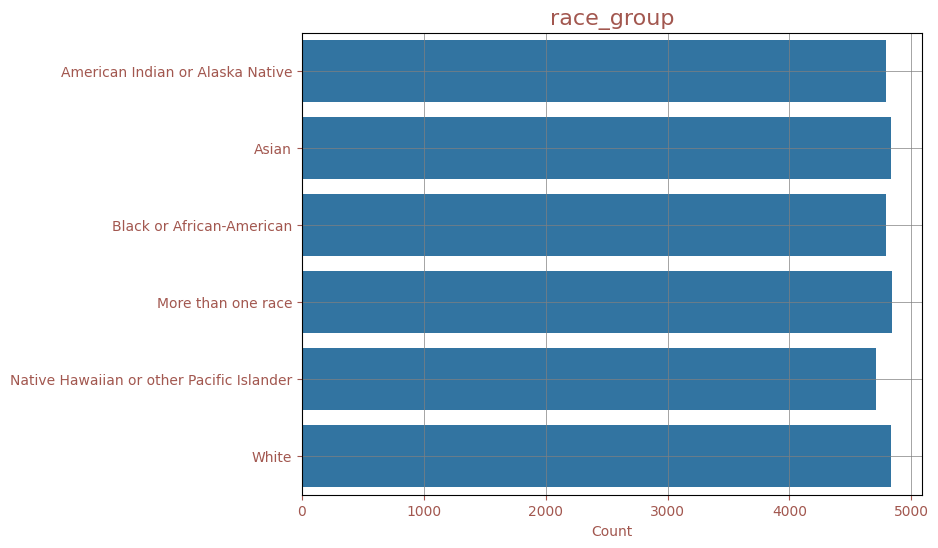

In [ ]:
md.eda.bar_chart('race_group')

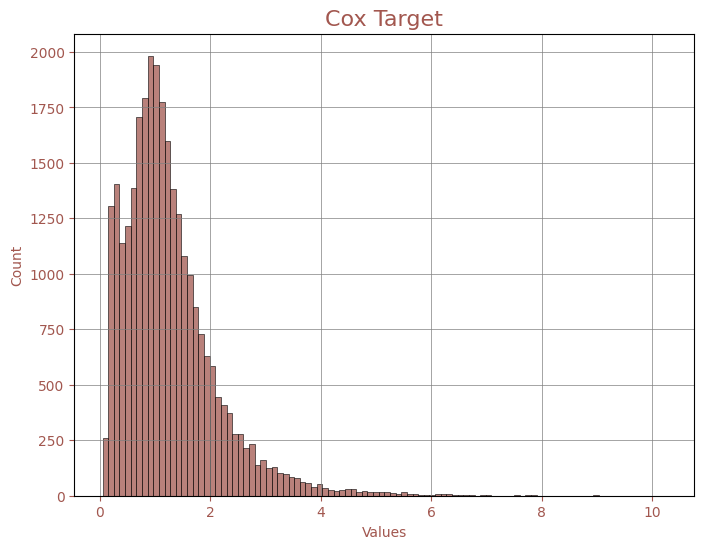

In [ ]:
md.eda.distribution_plot('target1', 'Cox Target')

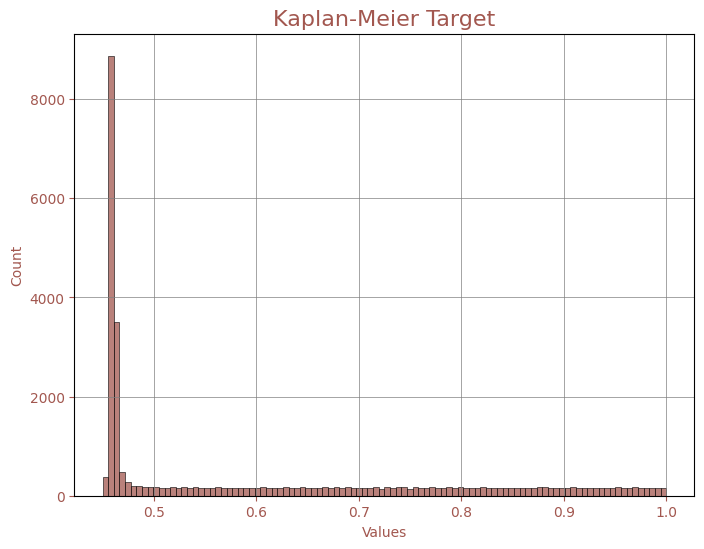

In [ ]:
md.eda.distribution_plot('target2', 'Kaplan-Meier Target')

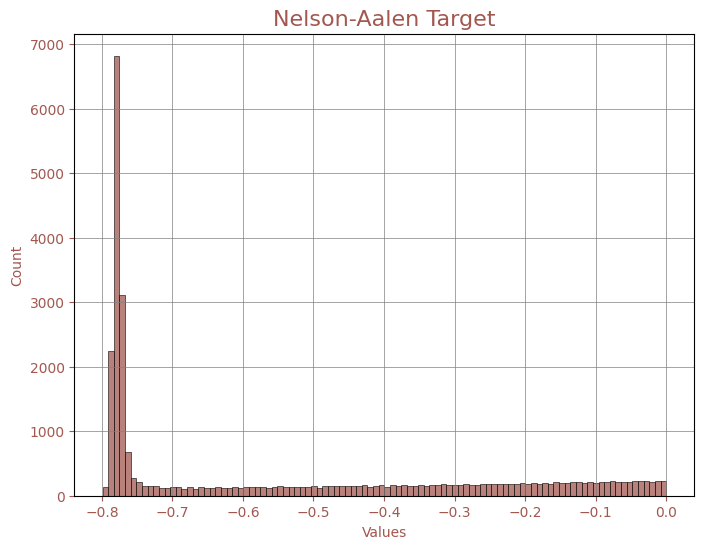

In [ ]:
md.eda.distribution_plot('target3', 'Nelson-Aalen Target')

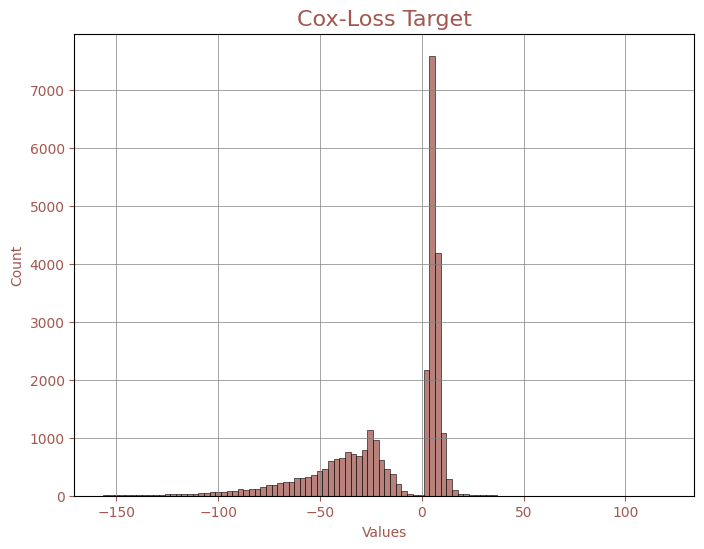

In [ ]:
md.eda.distribution_plot('target4', 'Cox-Loss Target')

In [ ]:
fe.info(df_train)


Shape of dataframe: (28800, 64)
Memory usage: 4.49 MB

   ID                       dri_score psych_disturb    cyto_score diabetes  \
0   0  N/A - non-malignant indication            No       Unknown       No   
1   1                    Intermediate            No  Intermediate       No   
2   2  N/A - non-malignant indication            No       Unknown       No   
3   3                            High            No  Intermediate       No   
4   4                            High            No       Unknown       No   

   hla_match_c_high  hla_high_res_8          tbi_status arrhythmia  \
0              -1.0             6.0              No TBI         No   
1               2.0             8.0  TBI +- Other, >cGy         No   
2               2.0             8.0              No TBI         No   
3               2.0             8.0              No TBI         No   
4               2.0             8.0              No TBI         No   

   hla_low_res_6        graft_type vent_hist renal_iss

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">Cox比例ハザードモデルによる予測</p>

- 目的変数
    - target1
- 予測モデル
    - lgbm
    - catboost

In [ ]:
# CatBoost
ctb1_models, ctb1_oof_preds = md.train_model(CFG.ctb_params, target='target1', title='CatBoost')

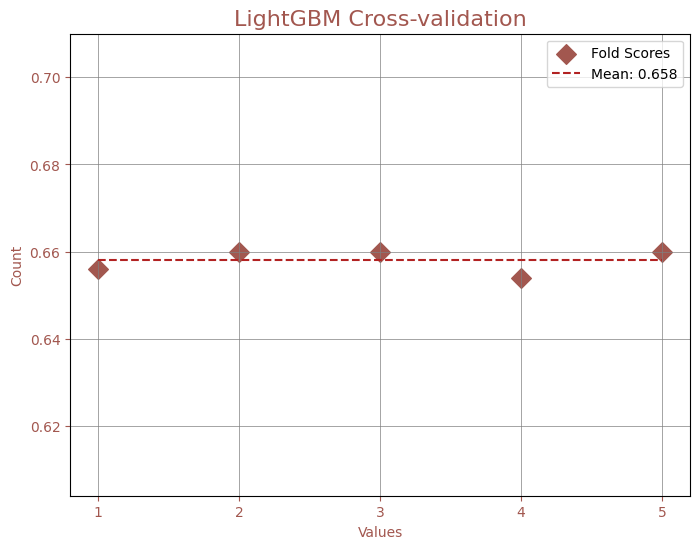

Overall Stratified C-Index Score for LightGBM: 0.6596


In [ ]:
# LightGBM
lgb1_models, lgb1_oof_preds = md.train_model(CFG.lgb_params, target='target1', title='LightGBM')

In [ ]:
ctb1_preds = md.infer_model(test_data, ctb1_models)

In [ ]:
lgb1_preds = md.infer_model(test_data, lgb1_models)

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">カプラン・マイヤー推定量による予測</p>

- 目的変数
    - target2
- 予測モデル
    - lgbm
    - catboost

In [ ]:
ctb2_models, ctb2_oof_preds = md.train_model(CFG.ctb_params, target='target2', title='CatBoost')

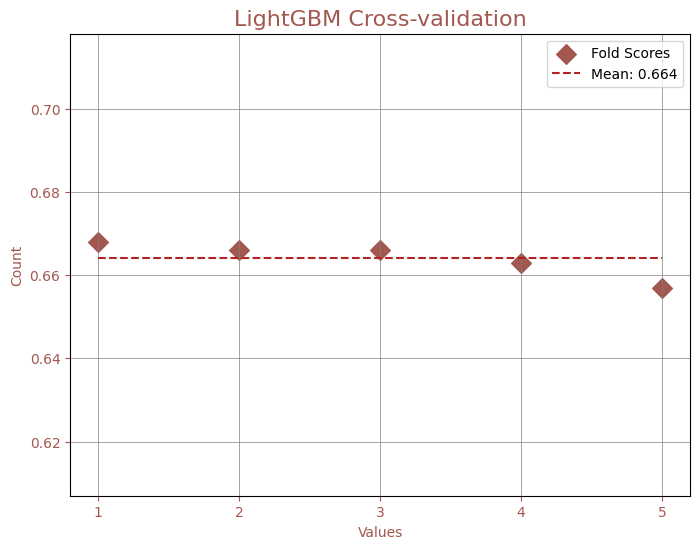

Overall Stratified C-Index Score for LightGBM: 0.6668


In [ ]:
lgb2_models, lgb2_oof_preds = md.train_model(CFG.lgb_params, target='target2', title='LightGBM')

In [ ]:
ctb2_preds = md.infer_model(test_data, ctb2_models)

In [ ]:
lgb2_preds = md.infer_model(test_data, lgb2_models)

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">ネルソン・アーレン推定量による予測</p>

- 目的変数
    - target3
- 予測モデル
    - lgbm
    - catboost

In [ ]:
ctb3_models, ctb3_oof_preds = md.train_model(CFG.ctb_params, target='target3', title='CatBoost')

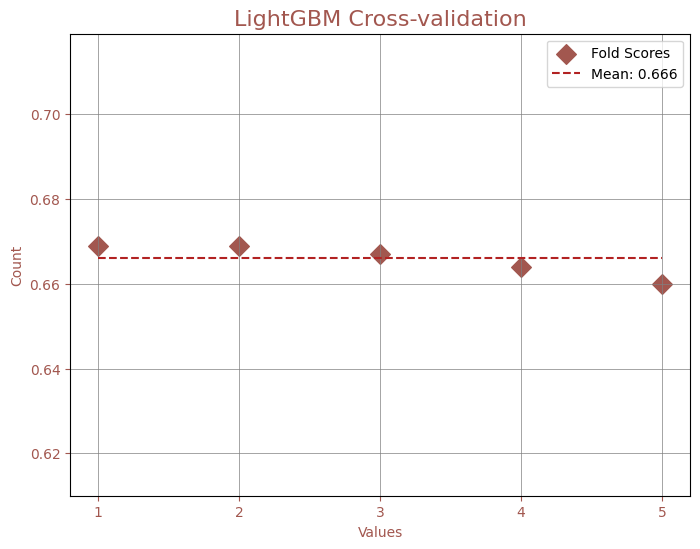

Overall Stratified C-Index Score for LightGBM: 0.6691


In [ ]:
lgb3_models, lgb3_oof_preds = md.train_model(CFG.lgb_params, target='target3', title='LightGBM')

In [ ]:
ctb3_preds = md.infer_model(test_data, ctb3_models)

In [ ]:
lgb3_preds = md.infer_model(test_data, lgb3_models)

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">Cox-Lossによる予測</p>

- 目的変数
    - target4
- 予測モデル
    - catboost
        - 木の深さ優先
        - 損失最小優先

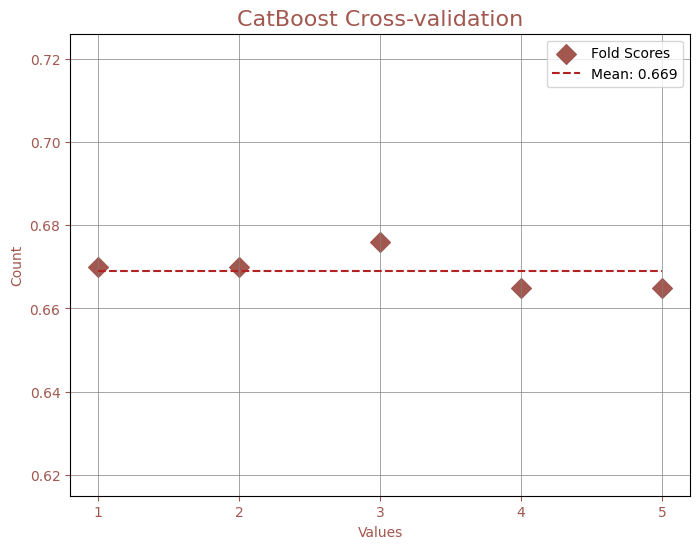

Overall Stratified C-Index Score for CatBoost: 0.6704


In [ ]:
# 木の深さ優先
cox1_models, cox1_oof_preds = md.train_model(CFG.cox1_params, target='target4', title='CatBoost')

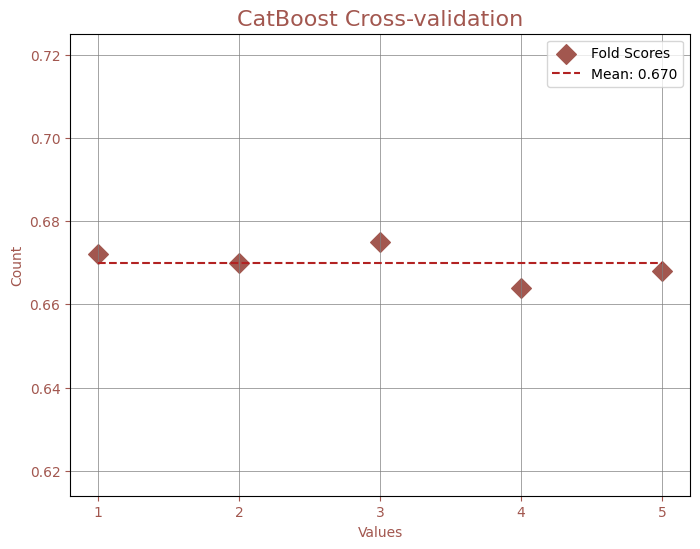

Overall Stratified C-Index Score for CatBoost: 0.6712


In [ ]:
# 損失最小優先
cox2_models, cox2_oof_preds = md.train_model(CFG.cox2_params, target='target4', title='CatBoost')

In [ ]:
cox1_preds = md.infer_model(test_data, cox1_models)

In [ ]:
cox2_preds = md.infer_model(test_data, cox2_models)

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">ニューラルネットワーク</p>

In [ ]:
class CatEmbeddings(nn.Module): # カテゴリ変数を埋め込みベクトルに変換し、さらに線形変換
    def __init__(self, projection_dim, categorical_cardinality, embedding_dim):
        super(CatEmbeddings, self).__init__()
        # 各カテゴリ変数の埋め込みレイヤーを作成
        self.embeddings = nn.ModuleList([
            nn.Embedding(cardinality, embedding_dim)
            for cardinality in categorical_cardinality
        ])
        # 埋め込みベクトルの次元を projection_dim に変換
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim * len(categorical_cardinality), projection_dim),
            nn.GELU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x_cat):
        x_cat = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, dim=1)
        return self.projection(x_cat)


class NN(nn.Module):
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            dropout: float = 0
    ):
        super(NN, self).__init__()
        self.embeddings = CatEmbeddings(projection_dim, categorical_cardinality, embedding_dim)
        self.mlp = nn.Sequential(
            ODST(projection_dim + continuous_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout)
        )
        self.out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x_cat, x_cont):
        x = self.embeddings(x_cat)
        x = torch.cat([x, x_cont], dim=1)
        x = self.dropout(x)
        x = self.mlp(x)
        return self.out(x), x
@functools.lru_cache
def combinations(N):
    ind = torch.arange(N)
    comb = torch.combinations(ind, r=2)
    return comb  # CPU 上でそのまま使う
class LitNN(pl.LightningModule):
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            lr: float = 1e-3,
            dropout: float = 0.2,
            weight_decay: float = 1e-3,
            aux_weight: float = 0.1,
            margin: float = 0.5,
            race_index: int = 0
    ):
        super(LitNN, self).__init__()
        self.save_hyperparameters()
        self.model = NN(
            continuous_dim=self.hparams.continuous_dim,
            categorical_cardinality=self.hparams.categorical_cardinality,
            embedding_dim=self.hparams.embedding_dim,
            projection_dim=self.hparams.projection_dim,
            hidden_dim=self.hparams.hidden_dim,
            dropout=self.hparams.dropout
        )
        self.targets = []
        self.aux_cls = nn.Sequential(
            nn.Linear(self.hparams.hidden_dim, self.hparams.hidden_dim // 3),
            nn.GELU(),
            nn.Linear(self.hparams.hidden_dim // 3, 1)
        )
    def on_before_optimizer_step(self, optimizer):
        # Compute the 2-norm for each layer
        # If using mixed precision, the gradients are already unscaled here
        norms = grad_norm(self.model, norm_type=2)
        self.log_dict(norms)

    def forward(self, x_cat, x_cont):
        x, emb = self.model(x_cat, x_cont)
        return x.squeeze(1), emb

    def training_step(self, batch, batch_idx):
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        aux_pred = self.aux_cls(emb).squeeze(1)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        aux_loss = nn.functional.mse_loss(aux_pred, y, reduction='none')
        aux_mask = efs == 1
        aux_loss = (aux_loss * aux_mask).sum() / aux_mask.sum()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("race_loss", race_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        self.log("aux_loss", aux_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        return loss + aux_loss * self.hparams.aux_weight

    def get_full_loss(self, efs, x_cat, y, y_hat):
        loss = self.calc_loss(y, y_hat, efs)
        race_loss = self.get_race_losses(efs, x_cat, y, y_hat)
        loss += 0.1 * race_loss
        return loss, race_loss

    def get_race_losses(self, efs, x_cat, y, y_hat):
        races = torch.unique(x_cat[:, self.hparams.race_index])
        race_losses = []
        for race in races:
            ind = x_cat[:, self.hparams.race_index] == race
            race_losses.append(self.calc_loss(y[ind], y_hat[ind], efs[ind]))
        race_loss = sum(race_losses) / len(race_losses)
        races_loss_std = sum((r - race_loss)**2 for r in race_losses) / len(race_losses)
        return torch.sqrt(races_loss_std)

    def calc_loss(self, y, y_hat, efs):
        N = y.shape[0]
        comb = combinations(N)
        comb = comb[(efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)]
        pred_left = y_hat[comb[:, 0]]
        pred_right = y_hat[comb[:, 1]]
        y_left = y[comb[:, 0]]
        y_right = y[comb[:, 1]]
        y = 2 * (y_left > y_right).int() - 1
        loss = nn.functional.relu(-y * (pred_left - pred_right) + self.hparams.margin)
        mask = self.get_mask(comb, efs, y_left, y_right)
        loss = (loss.double() * (mask.double())).sum() / mask.sum()
        return loss

    def get_mask(self, comb, efs, y_left, y_right):
        # mask1 = (efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)
        left_outlived = y_left >= y_right
        left_1_right_0 = (efs[comb[:, 0]] == 1) & (efs[comb[:, 1]] == 0)
        mask2 = (left_outlived & left_1_right_0)
        right_outlived = y_right >= y_left
        right_1_left_0 = (efs[comb[:, 1]] == 1) & (efs[comb[:, 0]] == 0)
        mask2 |= (right_outlived & right_1_left_0)
        mask2 = ~mask2
        mask = mask2
        return mask

    def validation_step(self, batch, batch_idx):
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        cindex, metric = self._calc_cindex()
        self.log("cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()

    def _calc_cindex(self):
        y = torch.cat([t[0] for t in self.targets]).cpu().numpy()
        y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy()
        efs = torch.cat([t[2] for t in self.targets]).cpu().numpy()
        races = torch.cat([t[3] for t in self.targets]).cpu().numpy()
        metric = self._metric(efs, races, y, y_hat) #人種ごとの層別C-index
        # cindex = concordance_index(y, y_hat, efs) # 全体のC-index
        return metric
    def _metric(self, efs, races, y, y_hat):
        metric_list = []
        for race in np.unique(races):
            y_ = y[races == race]
            y_hat_ = y_hat[races == race]
            efs_ = efs[races == race]
            metric_list.append(concordance_index(y_, y_hat_, efs_))
        metric = float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))
        return metric
    def test_step(self, batch, batch_idx):
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("test_loss", loss)
        return loss
    def on_test_epoch_end(self) -> None:
        # cindex,
        metric = self._calc_cindex()
        self.log("test_cindex", metric, on_epoch=True, prog_bar=True, logger=True) #人種ごとの層別C-index
        # self.log("test_cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True) #全体のC-index
        self.targets.clear()
    def configure_optimizers(self): # 最適化手法の設定
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler_config = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=45,
                eta_min=6e-3
            ),
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

In [ ]:
pl.seed_everything(42)
def train_final(X_num_train, dl_train, dl_val, transformers, hparams=None, categorical_cols=None):
    # ハイパーパラメータのデフォルト値設定
    if hparams is None:
        hparams = {
            "embedding_dim": 16,         # 埋め込み層の次元数。入力データを16次元のベクトル空間に変換
            "projection_dim": 112,       # 射影層の次元数。特徴量を112次元の空間に変換
            "hidden_dim": 56,           # 隠れ層のニューロン数。中間層で56個のユニットを使用
            "lr": 0.06464861983337984,  # 学習率。モデルの重みを更新する際のステップサイズ
            "dropout": 0.05463240181423116,  # ドロップアウト率。過学習を防ぐために約5.5%のニューロンをランダムに無効化
            "aux_weight": 0.26545778308743806,  # 補助損失の重み。全体の損失関数における補助タスクの寄与度
            "margin": 0.2588153271003354,  # マージン値。分類や距離学習などにおける決定境界からの最小距離
            "weight_decay": 0.0002773544957610778  # 重み減衰係数。L2正則化の強さを制御し、過学習を抑制
        }
    # モデルインスタンスの生成
    model = LitNN(
        continuous_dim=X_num_train.shape[1],
        categorical_cardinality=[len(t.classes_) for t in transformers],
        race_index=categorical_cols.index("race_group"),
        **hparams
    )
    # チェックポイントコールバック：検証ロス（val_loss）が最小のモデルを保存
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        filename="best-checkpoint"
    )
    # Trainerの初期化
    trainer = pl.Trainer(
        accelerator='cpu',  # GPUが使用可能なら "gpu" に変更
        max_epochs=60,
        enable_progress_bar=False,  # プログレスバーを無効化
        logger=False,  # ロガーを無効化
        callbacks=[
            checkpoint_callback,
            LearningRateMonitor(logging_interval='epoch'),
            StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=45, annealing_epochs=15)
        ],
    )
    # 学習の実施（引数名を明示的にして分かりやすく）
    trainer.fit(model, train_dataloaders=dl_train, val_dataloaders=dl_val)
    # チェックポイントから最良モデルを復元（best_model_pathが存在する場合）
    best_model_path = checkpoint_callback.best_model_path
    if best_model_path:
        print(f"Loading best model from: {best_model_path}")
        model = LitNN.load_from_checkpoint(best_model_path)
    else:
        print("No checkpoint found. Using last model state.")
    # 検証データでテスト実行（結果表示などが必要ならここで利用）
    trainer.test(model, dataloaders=dl_val)
    # 評価モードへ切替え
    model.eval()
    return model


def main(hparams):
    fe_train = FE()
    train_original = fe_train.apply_fe_nn(CFG.train_path)
    fe_test = FE()
    test = fe_test.apply_fe_nn(CFG.test_path)
    test['efs_time'] = 1
    test['efs'] = 1

    # 学習データの行数に合わせたOOF配列を用意
    oof_nn_preds = np.zeros(train_original.shape[0])
    test_nn_preds = np.zeros(test.shape[0])
    
    # StratifiedKFoldのセットアップ（ここでは例として5fold）
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for fold, (train_index, valid_index) in enumerate(
        kf.split(train_original, train_original.race_group.astype(str) + (train_original.age_at_hct == 0.044).astype(str))
    ):
        # foldごとにデータを分割
        train = train_original.iloc[train_index].copy()
        valid = train_original.iloc[valid_index].copy()
        
        # データ前処理（数値部分・カテゴリ部分の整形等）
        fe_nn = FE()
        X_cat_valid, X_num_train, X_num_valid, dl_train, dl_valid, transformers = fe_nn.preprocess_data(train, valid)
        categorical_cols, _ = fe_nn.get_feature_types(train)
        
        # モデルの学習
        model = train_final(X_num_train, dl_train, dl_valid, transformers, hparams, categorical_cols=categorical_cols)
        
        # 検証データに対する予測
        # ※入力テンソルの作成（GPU使用の場合はto(device)等を追加）
        with torch.no_grad():
            pred_valid, _ = model.cpu().eval()(
                torch.tensor(X_cat_valid, dtype=torch.long),
                torch.tensor(X_num_valid, dtype=torch.float32)
            )
        # もともとのコードでは提出用に符号反転していたので同様に
        oof_nn_preds[valid_index] = -pred_valid.detach().cpu().numpy().reshape(-1)
        
        # testデータに対する予測（foldごとに同じ手順で処理）
        # ここでは train のうち fold 用の部分を使ってテストに対する予測を実施
        X_cat_test, _, X_num_test, _, _, _ = fe_nn.preprocess_data(train, test)
        with torch.no_grad():
            pred_test, _ = model.cpu().eval()(
                torch.tensor(X_cat_test, dtype=torch.long),
                torch.tensor(X_num_test, dtype=torch.float32)
            )
        test_nn_preds += -pred_test.detach().cpu().numpy().reshape(-1)
        
    # 各foldのtest予測の平均を最終のNNテスト予測とする
    test_nn_preds /= kf.n_splits
    # NNモデルの結果として、OOFとTest予測の両方を返す
    return oof_nn_preds, test_nn_preds

Seed set to 42


In [ ]:
nn_oof_preds, nn_test_preds = main(hparams=None)

Test shape: (3, 70)
Train shape: (28800, 72)
There are 69 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | NN         | 173 K  | train
1 | aux_cls | Sequential | 1.0 K  | train
-----------------------------------------------
173 K     Trainable params
769       Non-trainable params
174 K     Total params
0.699     Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Swapping scheduler `CosineAnnealingLR` for `SWALR`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=61` reached.


Loading best model from: c:\Users\eikik\python\kaggle\CIBMTR\lightning_logs\version_28\checkpoints\best-checkpoint.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6802599430084229     │
│    test_cindex_simple     │    0.6927380561828613     │
│         test_loss         │    0.1811044855840621     │
└───────────────────────────┴───────────────────────────┘

There are 69 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'sex_match_bool', 'is_cyto_score_same', 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | NN         | 173 K  | train
1 | aux_cls | Sequential | 1.0 K  | train
-----------------------------------------------
173 K     Trainable params
769       Non-trainable params
174 K     Total params
0.699     Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


There are 69 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'sex_match_bool', 'is_cyto_score_same', 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Swapping scheduler `CosineAnnealingLR` for `SWALR`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=61` reached.


Loading best model from: c:\Users\eikik\python\kaggle\CIBMTR\lightning_logs\version_29\checkpoints\best-checkpoint.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6777530908584595     │
│    test_cindex_simple     │    0.6854519248008728     │
│         test_loss         │    0.18494712011972278    │
└───────────────────────────┴───────────────────────────┘

There are 69 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'sex_match_bool', 'is_cyto_score_same', 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | NN         | 173 K  | train
1 | aux_cls | Sequential | 1.0 K  | train
-----------------------------------------------
173 K     Trainable params
769       Non-trainable params
174 K     Total params
0.699     Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


There are 69 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'sex_match_bool', 'is_cyto_score_same', 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Swapping scheduler `CosineAnnealingLR` for `SWALR`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=61` reached.


Loading best model from: c:\Users\eikik\python\kaggle\CIBMTR\lightning_logs\version_30\checkpoints\best-checkpoint.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6842361688613892     │
│    test_cindex_simple     │    0.6926054954528809     │
│         test_loss         │    0.18174432024319173    │
└───────────────────────────┴───────────────────────────┘

There are 69 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'sex_match_bool', 'is_cyto_score_same', 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | NN         | 173 K  | train
1 | aux_cls | Sequential | 1.0 K  | train
-----------------------------------------------
173 K     Trainable params
769       Non-trainable params
174 K     Total params
0.699     Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


There are 69 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'sex_match_bool', 'is_cyto_score_same', 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Swapping scheduler `CosineAnnealingLR` for `SWALR`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=61` reached.


Loading best model from: c:\Users\eikik\python\kaggle\CIBMTR\lightning_logs\version_31\checkpoints\best-checkpoint.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6863095760345459     │
│    test_cindex_simple     │    0.6993235945701599     │
│         test_loss         │    0.17773979573569812    │
└───────────────────────────┴───────────────────────────┘

There are 69 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'sex_match_bool', 'is_cyto_score_same', 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | NN         | 173 K  | train
1 | aux_cls | Sequential | 1.0 K  | train
-----------------------------------------------
173 K     Trainable params
769       Non-trainable params
174 K     Total params
0.699     Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


There are 69 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'sex_match_bool', 'is_cyto_score_same', 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Swapping scheduler `CosineAnnealingLR` for `SWALR`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=61` reached.


Loading best model from: c:\Users\eikik\python\kaggle\CIBMTR\lightning_logs\version_32\checkpoints\best-checkpoint.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6731411814689636     │
│    test_cindex_simple     │    0.6812833547592163     │
│         test_loss         │    0.18770810098263016    │
└───────────────────────────┴───────────────────────────┘

There are 69 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'sex_match_bool', 'is_cyto_score_same', 

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">アンサンブル</p>

In [ ]:
oof_preds = [
    ctb1_oof_preds, 
    lgb1_oof_preds, 
    ctb2_oof_preds, 
    lgb2_oof_preds, 
    ctb3_oof_preds, 
    lgb3_oof_preds, 
    cox1_oof_preds,
    cox2_oof_preds,
    nn_oof_preds
]

In [ ]:
preds = [
    ctb1_preds, 
    lgb1_preds, 
    ctb2_preds, 
    lgb2_preds, 
    ctb3_preds, 
    lgb3_preds,
    cox1_preds,
    cox2_preds,
    nn_test_preds
]

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">アンサンブル結果の精度評価</p>

In [ ]:
# oof_preds（各予測モデル×）の中身について順位付け（値の小さい順）した結果を格納
ranked_oof_preds = np.array([rankdata(p) for p in oof_preds])

In [ ]:
ensemble_oof_preds = np.dot(CFG.weights, ranked_oof_preds)

In [3]:
md.targets.validate_model(ensemble_oof_preds, 'Ensemble Model')

NameError: name 'md' is not defined

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">テストデータの予測</p>

In [ ]:
ranked_preds = np.array([rankdata(p) for p in preds])

In [ ]:
ensemble_preds = np.dot(CFG.weights, ranked_preds)

In [ ]:
subm_data = pd.read_csv(CFG.subm_path)
subm_data['prediction'] = ensemble_preds

In [4]:
subm_data.to_csv('submission.csv', index=False)
display(subm_data.head())

NameError: name 'subm_data' is not defined